# Molecule transformers

## 1. input embedding 

## 2. Self attention and Feed forward

## 3. details

Activation function : gelu

The maximum length of positional embedding : 100

hidden dimension : 512

embedded dimension : 128

layers 8, attention heads 8

masked probability for each token : 0.15

masking probability : 0.8 | trainsition probability : 0.2

the trunacation of the molecule sequence can be detected by checking the absence of \[begin\]/\[END\]

## 4. Questions
Is it OK to remain the synonyms for SMILES representations?

Should we use mask?? or not?? (Masking for attention: mask future words)

## 5. Note
Somehow, (guessing: just underflow problems of the CPU itself) CPU-based learning show poor convergence speed.

Most of them just being (C,4). We should add the class weights.

BERT based model is highly sensitive for learning rates...

masking, 0.0001 lr = 0.26 converge

masking, 0.00005 lr, gelu, norm = 0.30 converge

no masking, 0.00005 lr, gelu = 1.11 converge 

For the label data, \<pad\> also have to be a masked symbol.

In [1]:
import torch
import torch.nn
import torchtext
import pytorch_warmup as warmup
from torchtext.data import Iterator
from torchtext.data.utils import get_tokenizer
import random
import math

In [2]:
class TransformerModel(torch.nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.1):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.ninp = ninp
        
        ###################################################################
        self.pos_encoder = torch.nn.Embedding(100, ninp)
        self.encoder = torch.nn.Embedding(ntoken, ninp)
        
        ###################################################################
        self.layer_norm = torch.nn.LayerNorm([ninp])
        self.output_layer_norm = torch.nn.LayerNorm([ntoken])
        self.input_layer_norm = torch.nn.LayerNorm([ninp])
        
        encoder_layers = TransformerEncoderLayer(d_model=ninp,
                                                 nhead=nhead,
                                                 dim_feedforward=nhid,
                                                 dropout=dropout,
                                                 activation='gelu')
        
        self.transformer_encoder = TransformerEncoder(encoder_layers,
                                                      nlayers,
                                                      norm=self.layer_norm)

        self.dropout = torch.nn.Dropout(dropout)
        ###################################################################
        self.decoder = torch.nn.Linear(ninp, ntoken, bias=False) ## embedded -> seq
        self.decoder_bias = torch.nn.Parameter(torch.zeros(ntoken))
        self.init_weights()


    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.normal_(mean=0.0, std=1.0)
        self.decoder.weight.data.normal_(mean=0.0, std=1.0)
        self.decoder_bias.data.zero_()
        
        self.input_layer_norm.weight.data.fill_(1.0)
        self.input_layer_norm.bias.data.zero_()
        self.output_layer_norm.weight.data.fill_(1.0)
        self.output_layer_norm.bias.data.zero_()
        self.layer_norm.weight.data.fill_(1.0)
        self.layer_norm.bias.data.zero_()
    

    def forward(self, src):
        pos = torch.arange(0,100).long().to(src.device)
        
        mol_token_emb = self.encoder(src)
        pos_emb = self.pos_encoder(pos) ### Input embedding = positional embedding + normal embedding
        input_emb = pos_emb + mol_token_emb
        input_emb = self.input_layer_norm(input_emb) ## Should we use this?
        input_emb = self.dropout(input_emb)
        input_emb = input_emb.transpose(0, 1) ## Should we transpose this??..
        
        attention_mask = torch.ones_like(src).to(src.device)
        #attention_mask = torch.ones(src.size()[0:1]).to(src.device)
        attention_mask = attention_mask.masked_fill(src!=1., 0.)
        attention_mask = attention_mask.bool().to(src.device)
        
        output = self.transformer_encoder(input_emb)#, src_key_padding_mask=attention_mask) ### Self-attention layers : dim = ninp
        output = self.decoder(output) + self.decoder_bias ### decoding

        return output

# Load and batch data & tokenize

In [3]:
import re

test_file = open('./test.txt', 'r')

def mol_tokenize(mol_str):
    tokens = []
    long_chr = False
    current_str = ''
    i = 0
    while i < len(mol_str):
        if mol_str[i] == '[':
            long_chr = True
        elif mol_str[i] == ']':
            long_chr = False
        else:
            current_str += mol_str[i]
        
        if not long_chr:
            tokens.append(current_str)
            current_str = ''
        i += 1

    return tokens

def valid_SMILE(mol_str):
    template = re.compile('(^([^J][0-9BCOHNSOPrIFla@+\-\[\]\(\)\\\/%=#$]{6,})$)', re.I)
    match = template.match(mol_str)
    return bool(match)

def tokenize_label(mol_str):
    mol_str_list = list(mol_str)
    mol_str_list[0] = '&'
    if mol_str_list[-1] == '$':
        mol_str_list[-1] = '&'
    return mol_str_list

test_file.close()

In [4]:
train_file = './CID-SMILES_train_10M.txt'

smile_mol_tokenizer = torchtext.data.Field(init_token='<REP>', ### $ is the [BEGIN]
                                          pad_token='<PAD>',
                                          tokenize=list,
                                          #eos_token='<END>', ### will replace by $ as well ([BEGIN], [END] = $)
                                          fix_length=100,
                                          batch_first=True) 

smile_mol_masked_tokenizer = torchtext.data.Field(fix_length=100,
                                                 init_token='&',
                                                 pad_token='&',
                                                 tokenize=tokenize_label,
                                                 batch_first=True)

smile_data_training = torchtext.data.TabularDataset(path=train_file,
                                          format='csv',
                                          fields=[('input', smile_mol_tokenizer), ('output', smile_mol_masked_tokenizer)])


train_data, test_data = smile_data_training.split(split_ratio=0.8)

smile_mol_tokenizer.build_vocab(smile_data_training)
#smile_mol_masked_tokenizer.build_vocab(smile_data_training)
smile_mol_masked_tokenizer.vocab = smile_mol_tokenizer.vocab

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_batch, test_batch = torchtext.data.BucketIterator.splits((train_data, test_data),
                                                              batch_size=128,
                                                              shuffle=True,
                                                              device=device,
                                                              repeat=False,
                                                              sort=False)

/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.6/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)
/usr/local/lib/python3.6/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes f

# Training process

In [5]:
n_tokens = 73 #len(smile_mol_tokenizer.vocab.stoi)
mol_emsize = 128 # Embedded molecule sizes
n_layers = 8 # Number of attentions and feed-forwards
n_head = 8 # Attention heads
n_hid = 512 # feed forward dim
lr = 0.0001
epochs = 3

token_idx = smile_mol_tokenizer.vocab.stoi
ignored_token = token_idx['<unk>']
untargeted_tokens = ['<unk>', '<PAD>', '<REP>', '$', ' ']

counts = smile_mol_tokenizer.vocab.freqs
sum_counts = 0
for tok, cnt in counts.items():
    if not tok in untargeted_tokens:
        sum_counts += cnt

class_weights = [0., 0., 0.] ## <unk>, <PAD>, <REP>
counts_sorted = sorted(counts.items(), key=lambda x: x[1], reverse=True)
for tok, cnt in counts_sorted:
    if not tok in untargeted_tokens:
        #class_weights.append(math.sqrt(sum_counts/cnt)/(n_tokens-5))
        class_weights.append((sum_counts/cnt)/(n_tokens-5))
        #class_weights.append(math.log(sum_counts/cnt)/(n_tokens-5))
    else:
        class_weights.append(0.)

criterion = torch.nn.CrossEntropyLoss(ignore_index=ignored_token, weight=torch.Tensor(class_weights).to(device))
model = TransformerModel(n_tokens, mol_emsize, n_head, n_hid, n_layers).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
decay_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1., gamma=0.99)
#decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_batch)*epochs)
#warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)

print(class_weights)
print(smile_mol_tokenizer.vocab.stoi)
print(smile_mol_masked_tokenizer.vocab.stoi)

[0.0, 0.0, 0.0, 0.04139340927609474, 0.1038682920520571, 0.0, 0.15979909912428306, 0.15981597452127924, 0.2559363249863793, 0.3337008863582542, 0.0, 0.4310528888390257, 0.4653011009586701, 0.6371248059616186, 0.831786552747675, 0.8943316074439386, 0.8946191734942505, 1.2255613721160936, 1.2669464836970066, 1.6691812337163514, 2.610538001591529, 2.719151441369674, 2.983799368064078, 3.1976218759495025, 5.391082222688365, 7.510872752179333, 8.321929945428023, 8.45075934388082, 9.416614870610303, 9.422221963879428, 9.596935291420957, 16.81806717238445, 26.55713010972294, 26.618449055318052, 30.44916293601375, 31.97429559845434, 37.584465928211216, 55.59724149224073, 55.709990146262804, 57.665863055250426, 57.69647914912809, 58.117114578938406, 58.20225377613831, 58.272015336959456, 58.40327002458864, 58.411117940916085, 58.43975763496383, 58.52121064463925, 58.55784581751398, 58.56759199947038, 58.57269843726906, 58.579663196730635, 58.60010271633871, 58.62055650437234, 58.658713052605826

In [ ]:
import time

token_idx = smile_mol_tokenizer.vocab.stoi
untargeted_tokens = [token_idx['<unk>'], token_idx['<PAD>'], token_idx['<REP>'], token_idx['$']]
mask_token = token_idx[' ']
loss_history = []
acc_history = []

def train():
    model.train()
    total_loss = 0.
    start_time = time.time()
    i = 0
    for batch in train_batch:
        data, targets = batch.input, batch.output
        optimizer.zero_grad()

        predicts = model(data).transpose(0,1)
        loss = criterion(predicts.reshape(-1,n_tokens), targets.view(-1))
        loss.backward()
        #torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        schedule_interval = 1000
        
        if i % log_interval == 0 and i > 0:
            ## ACC check
            masked_num = 0
            masked_hit = 0
            for j in range(len(batch)):
                for k in range(len(batch.output[j])):
                    if batch.output[j][k] in untargeted_tokens:
                        continue
                    if batch.input[j][k] == mask_token:
                        masked_num += 1
                        if batch.output[j][k] == torch.max(predicts, 2)[1][j][k]:
                            masked_hit += 1
            #print(torch.max(predicts, 2)[1][j][k], batch.output[j][k])
    
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.10f} | ms/batch {:5.2f} | '
                  'loss {:5.8f} | acc {:6.4f}'.format(
                    epoch, i, len(train_batch), decay_scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, masked_hit/masked_num))
            total_loss = 0
            start_time = time.time()
        
            acc_history.append(masked_hit/masked_num)
        loss_history.append(loss)
        #warmup_scheduler.dampen()
        if i % schedule_interval == 0 and i > 0:
            decay_scheduler.step()
        i += 1
        

def evaluate(eval_model):
    eval_model.eval()
    total_loss = 0.
    with torch.no_grad():
        for batch in test_batch:
            data, targets = batch.input, batch.output
            predicts = eval_model(data).transpose(0,1)
            total_loss += len(data) * criterion(predicts.reshape(-1, n_tokens), targets.view(-1)).item()
    return total_loss / (len(test_batch) - 1)

best_val_loss = float("inf")
best_model = None

for epoch in range(1, epochs+1):
    epoch_start_time = time.time()
    train()

    val_loss = evaluate(model)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '.format(epoch,
                                                (time.time() - epoch_start_time), val_loss))
    print('-' * 89)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model


| epoch   1 |   200/62500 batches | lr 0.0000536268 | ms/batch 253.36 | loss 0.48709934 | acc 0.7154
| epoch   1 |   400/62500 batches | lr 0.0000536268 | ms/batch 181.77 | loss 0.48521880 | acc 0.7000
| epoch   1 |   600/62500 batches | lr 0.0000536268 | ms/batch 184.96 | loss 0.49718571 | acc 0.6955
| epoch   1 |   800/62500 batches | lr 0.0000536268 | ms/batch 212.74 | loss 0.47677010 | acc 0.7439
| epoch   1 |  1000/62500 batches | lr 0.0000536268 | ms/batch 215.14 | loss 0.48140769 | acc 0.7372
| epoch   1 |  1200/62500 batches | lr 0.0000530906 | ms/batch 216.11 | loss 0.48983846 | acc 0.7188
| epoch   1 |  1400/62500 batches | lr 0.0000530906 | ms/batch 214.71 | loss 0.47958730 | acc 0.7608
| epoch   1 |  1600/62500 batches | lr 0.0000530906 | ms/batch 213.62 | loss 0.47855030 | acc 0.7167
| epoch   1 |  1800/62500 batches | lr 0.0000530906 | ms/batch 213.62 | loss 0.47749521 | acc 0.7327
| epoch   1 |  2000/62500 batches | lr 0.0000530906 | ms/batch 213.59 | loss 0.47010500 | a

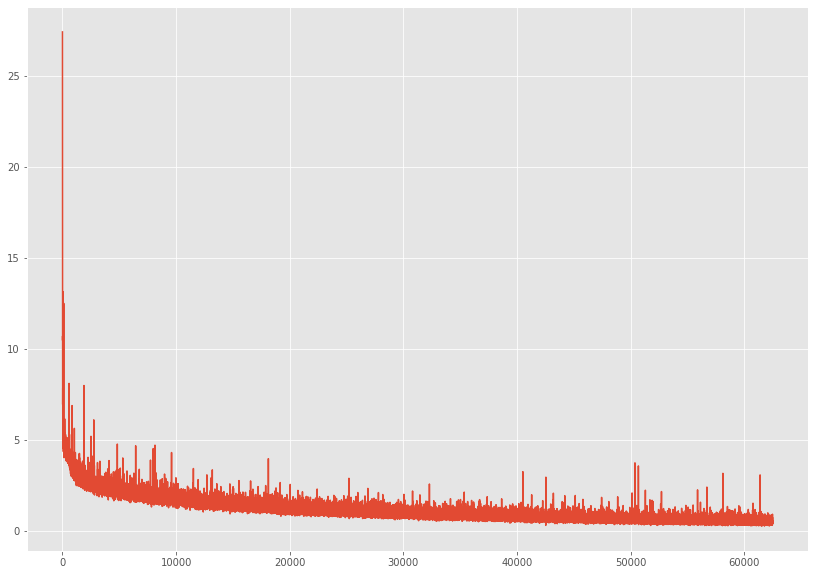

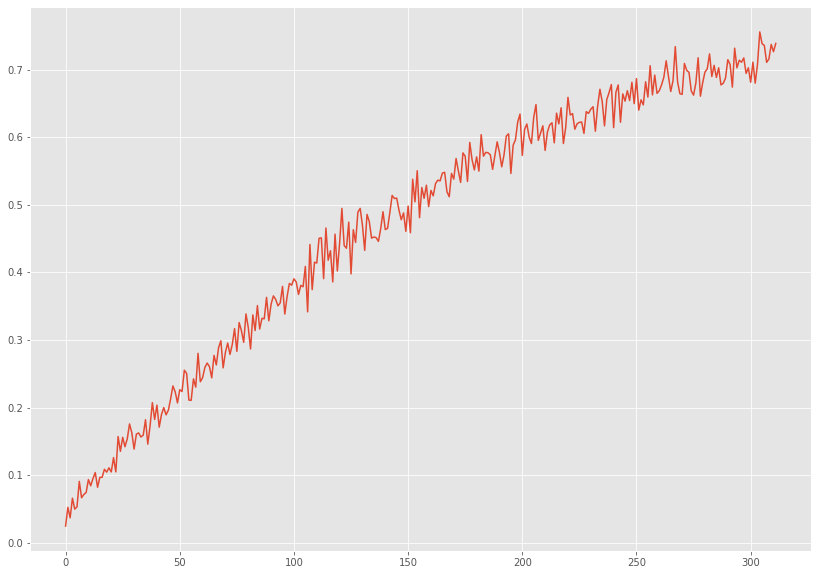

In [7]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("ggplot")

plt.figure(figsize=(14,10))
plt.plot(loss_history)
plt.show()

plt.figure(figsize=(14,10))
plt.plot(acc_history)
plt.show()

# Check accuracy

In [26]:
import numpy as np

print(smile_mol_tokenizer.vocab.stoi)
print(smile_mol_masked_tokenizer.vocab.stoi)

total_num = 0
total_hit = 0
total_masked_num = 0
total_masked_hit = 0

token_idx = smile_mol_tokenizer.vocab.stoi
untargeted_tokens = [token_idx['<unk>'], token_idx['<PAD>'], token_idx['<REP>'], token_idx['$']]
mask_token = token_idx[' ']

for batch in test_batch:
    predicts = model(batch.input).transpose(0,1)
    masked_num = 0
    masked_hit = 0
    predicted_val = torch.max(torch.softmax(predicts, 2), 2)[1]
    masked_num = (batch.output != token_idx['<unk>']).sum()
    masked_hit = torch.logical_and(batch.output - predicted_val == 0,
                                   predicted_val != token_idx['<unk>']).sum()
    print(masked_hit, masked_num)
    
    total_masked_num += masked_num
    total_masked_hit += masked_hit

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f70f84dc518>>, {'<unk>': 0, '<PAD>': 1, '<REP>': 2, 'C': 3, '=': 4, ' ': 5, ')': 6, '(': 7, 'O': 8, 'N': 9, '$': 10, '1': 11, '2': 12, '3': 13, '@': 14, ']': 15, '[': 16, '4': 17, 'H': 18, 'S': 19, '/': 20, 'F': 21, 'l': 22, '5': 23, '+': 24, '-': 25, '6': 26, '\\': 27, 'B': 28, '#': 29, 'r': 30, '7': 31, '8': 32, 'i': 33, 'P': 34, 'I': 35, '9': 36, '%': 37, 'n': 38, 's': 39, 'A': 40, '0': 41, 'b': 42, 'f': 43, 'o': 44, '.': 45, 'V': 46, 'M': 47, 'g': 48, 'y': 49, 'd': 50, 'D': 51, 'c': 52, 'Z': 53, 'k': 54, 't': 55, 'W': 56, 'e': 57, 'G': 58, 'm': 59, 'u': 60, 'K': 61, 'a': 62, 'T': 63, 'L': 64, 'R': 65, 'Y': 66, 'E': 67, 'h': 68, 'X': 69, 'p': 70, '*': 71, 'U': 72, '&': 0})
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f70f84dc518>>, {'<unk>': 0, '<PAD>': 1, '<REP>': 2, 'C': 3, '=': 4, ' ': 5, ')': 6, '(': 7, 'O': 8, 'N': 9, '$': 10, '1': 11, '2': 12, 

/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


tensor(883, device='cuda:0') tensor(1157, device='cuda:0')
tensor(827, device='cuda:0') tensor(1087, device='cuda:0')
tensor(775, device='cuda:0') tensor(1012, device='cuda:0')
tensor(817, device='cuda:0') tensor(1038, device='cuda:0')
tensor(814, device='cuda:0') tensor(1041, device='cuda:0')
tensor(836, device='cuda:0') tensor(1088, device='cuda:0')
tensor(803, device='cuda:0') tensor(1038, device='cuda:0')
tensor(842, device='cuda:0') tensor(1093, device='cuda:0')
tensor(819, device='cuda:0') tensor(1050, device='cuda:0')
tensor(809, device='cuda:0') tensor(1051, device='cuda:0')
tensor(800, device='cuda:0') tensor(1024, device='cuda:0')
tensor(814, device='cuda:0') tensor(1032, device='cuda:0')
tensor(808, device='cuda:0') tensor(1043, device='cuda:0')
tensor(834, device='cuda:0') tensor(1104, device='cuda:0')
tensor(913, device='cuda:0') tensor(1145, device='cuda:0')
tensor(811, device='cuda:0') tensor(1065, device='cuda:0')
tensor(935, device='cuda:0') tensor(1209, device='cuda:0

KeyboardInterrupt: 

In [29]:
print(float(total_masked_hit)/float(total_masked_num), total_masked_hit, total_masked_num)
#print(total_hit/total_num)
#total_num

0.7759391775801255 tensor(3628730, device='cuda:0') tensor(4676565, device='cuda:0')


In [56]:
print(torch.softmax(predicts, 2)[0])
print(torch.max(torch.softmax(predicts, 2)[0],1))
print(torch.max(predicts[0], 1))

tensor([[4.2446e-10, 1.2632e-10, 1.6027e-10,  ..., 1.1004e-10, 3.7088e-10,
         2.1725e-11],
        [5.7084e-10, 1.3802e-10, 4.4569e-10,  ..., 4.5578e-10, 5.1759e-10,
         7.0589e-11],
        [1.6776e-21, 1.4392e-16, 8.3949e-20,  ..., 2.4262e-18, 8.4264e-19,
         2.4547e-15],
        ...,
        [5.4010e-10, 2.5999e-10, 4.0919e-10,  ..., 6.7920e-10, 6.3277e-10,
         6.7412e-11],
        [5.5843e-10, 2.7174e-10, 4.1589e-10,  ..., 7.0569e-10, 6.4497e-10,
         6.6925e-11],
        [5.2239e-10, 2.7265e-10, 4.2240e-10,  ..., 6.9595e-10, 6.3384e-10,
         6.9012e-11]], device='cuda:0', grad_fn=<SelectBackward>)
torch.return_types.max(
values=tensor([0.4434, 0.4065, 1.0000, 0.8479, 0.9845, 0.9120, 0.9385, 0.9829, 0.9781,
        0.9563, 0.9545, 0.9769, 0.9810, 0.9135, 0.9393, 0.9689, 0.8979, 0.3405,
        0.8335, 0.9727, 0.3017, 0.9440, 0.9726, 0.9721, 0.9204, 0.9470, 0.9713,
        0.9431, 0.9448, 0.9745, 0.7832, 0.9186, 0.2524, 0.9173, 0.8088, 0.9755,
        0.

# Some meaningless tests(sandbox)

In [25]:
import numpy as np

def to_onehot(x, dim, n_classes):
    y = torch.zeros(dim, n_classes)
    y[range(y.shape[0]), x] = 1
    return y
    
for batch in train_batch:
    print(batch.input, batch.input.size())
    print(batch.output, batch.output.size())
    #print(torch.nn.functional.one_hot(batch.input, num_classes=72))
    if 3 in batch.input[0]:
        print("valid")
    break
    


AttributeError: 'Field' object has no attribute 'vocab'

In [23]:
smile_mol_tokenizer.vocab.extend
len(train_batch)

62500

In [44]:
#smile_mol_tokenizer.numericalize(train_data.examples[0].smile_mol) , train_data.examples[0].smile_mol
print(smile_mol_tokenizer.vocab.freqs)
print(smile_mol_tokenizer.vocab.stoi)
counts = list(smile_mol_tokenizer.vocab.freqs.values())
sum_counts = sum(counts)
class_weights = list(map(lambda x: math.log(sum_counts/x), counts))
class_weights = [1., 1., 1., 1.] + class_weights
smile_mol_tokenizer.vocab.stoi['&']

Counter({'&': 485736403, 'C': 209177395, '=': 83353404, ' ': 68580742, '(': 54095258, ')': 54094837, '$': 40000000, 'O': 33868304, 'N': 25969487, '1': 20135253, '2': 18606262, '3': 13515778, '@': 10026943, ']': 9931598, '[': 9930298, '4': 6977705, 'H': 6717831, 'S': 5200731, '/': 3294861, 'F': 3190941, 'l': 2983509, '5': 2649778, '+': 1757496, '-': 1342661, '\\': 1011873, '6': 1010657, 'B': 920186, '#': 914398, 'r': 902467, '.': 551023, '7': 496421, '8': 306970, 'i': 306592, 'P': 291803, 'I': 262700, '9': 213402, 'e': 155270, 'a': 149157, 'n': 144574, 'u': 136948, 'A': 134675, 'o': 133820, '%': 133775, 'M': 133475, 'g': 133144, 'Z': 132587, 'R': 132006, 'T': 131613, 's': 130767, 't': 130757, 'L': 130716, 'K': 130230, 'd': 130133, 'G': 129878, 'W': 129667, 'b': 128967, 'h': 128226, '0': 128218, 'V': 127918, 'c': 127825, 'Y': 126640, 'm': 126635, 'E': 126449, 'U': 126287, 'f': 126280, 'X': 126269, '*': 126264, 'p': 126129, 'k': 126088, 'y': 125909, 'D': 125659})
defaultdict(<bound method

3

In [ ]:
print(smile_mol_tokenizer.vocab.freqs)
total_count = sum(dict(smile_mol_tokenizer.vocab.freqs).values())
for k, v in smile_mol_tokenizer.vocab.freqs.items():
    print(k,v/total_count)

In [19]:
### Masking test ( padding mask)

for i in test_batch:
    print(i.input, i.input.size())
    print(torch.triu(torch.ones(len(i.input), len(i.input))).transpose(0,1))
    print(torch.ones_like(i.input), torch.ones_like(i.input).size())
    mask = torch.ones_like(i.input).masked_fill(i.input==1, 0.)
    print(mask, mask.size())
    #mask = mask.masked_fill(mask==1, 1.)
    #print(mask, mask.size())
    print(mask.bool())
    print(i.input.size()[0:1])
    break

tensor([[ 2, 10,  3,  ...,  1,  1,  1],
        [ 2, 10,  3,  ...,  1,  1,  1],
        [ 2, 10,  3,  ...,  1,  1,  1],
        ...,
        [ 2, 10,  3,  ...,  1,  1,  1],
        [ 2, 10,  5,  ...,  1,  1,  1],
        [ 2, 10,  3,  ...,  1,  1,  1]], device='cuda:0') torch.Size([128, 100])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0') torch.Size([128, 100])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1,

In [45]:
model.pos_encoder(torch.Tensor([5]).long().to(device))

tensor([[-4.8153e-05,  3.8672e-04,  2.4960e-04,  3.3104e-04,  3.7464e-04,
          8.0204e-05,  2.1391e-04,  5.1761e-04,  1.0686e-04,  2.6376e-04,
          2.5179e-04,  3.3603e-04,  3.1996e-04,  6.9726e-05,  4.8428e-06,
          2.7887e-04,  3.2558e-04,  3.0270e-05,  3.1651e-04,  7.3883e-05,
          5.1268e-04,  3.2044e-04, -6.5835e-05, -3.4273e-03,  4.1304e-04,
          2.7972e-04,  2.3859e-05,  2.8594e-05,  1.9375e-04,  3.5596e-04,
          3.0236e-05,  4.0236e-04,  2.8324e-04,  4.9524e-05,  2.6093e-04,
          3.0429e-04,  2.5857e-04,  3.4111e-04,  3.1446e-04, -3.0405e-05,
          2.3706e-04,  3.2580e-04,  3.3632e-04,  3.5923e-04,  4.5087e-03,
          2.9247e-04,  1.8522e-04,  6.8327e-07, -1.5304e-05,  3.7879e-04,
          6.3391e-05,  5.0813e-05,  3.9181e-04, -2.4256e-05,  2.8126e-04,
          3.8921e-04,  4.0253e-04,  3.3124e-04,  3.5538e-04,  7.9788e-05,
          1.8143e-04, -2.8732e-02,  2.5465e-04,  4.5708e-05, -1.9635e-03,
          3.9684e-04,  1.7820e-05,  3.

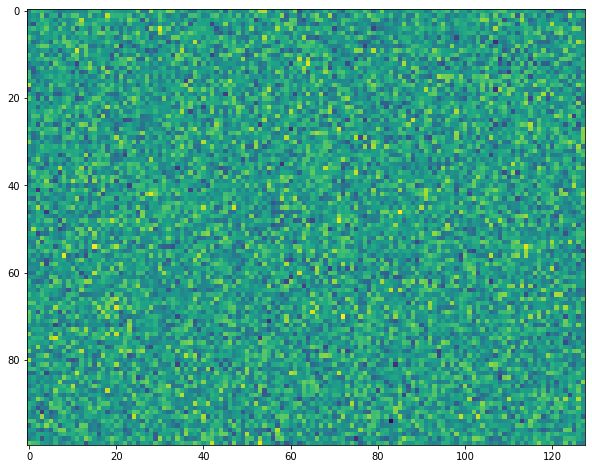

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

pos = torch.arange(0,100).long().to(device)
np_pos = model.pos_encoder(pos).cpu().detach().numpy()

plt.figure(figsize=(10,10))
plt.imshow(np_pos)
plt.show()
#model.decoder(model.encoder(i.input, src_key_padding_mask=None))

In [44]:
for i in test_batch:
    pos = torch.arange(0,100).long().to(device)
    inp = model.pos_encoder(pos) + model.encoder(i.input)

    attention_mask = torch.ones_like(i.input)
    attention_mask = attention_mask.masked_fill(i.input!=1., 0.)
    attention_mask = attention_mask.transpose(0,1).bool()
    
    #attention_mask = torch.ones(i.output.size()[0:1])
    print(attention_mask, attention_mask.size())
    
    encoding = model.transformer_encoder(inp, src_key_padding_mask=attention_mask)
    print(encoding[0], encoding.size())
    print(model.decoder(encoding)[0])
    print(model.decoder(encoding).view(-1, 73))
    break

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True]], device='cuda:0') torch.Size([100, 128])
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<SelectBackward>) torch.Size([128, 100, 128])
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan

In [29]:
inp = torch.arange(0,100).unsqueeze(0).transpose(0,1)
print(inp.size())
emb = torch.nn.Embedding(100, 32)
emb(inp).

SyntaxError: invalid syntax (<ipython-input-29-1195d0af9f65>, line 4)

In [10]:
for batch in test_batch:
    predicts = model(batch.input).transpose(0,1)
    masked_num = 0
    masked_hit = 0
    predicted_val = torch.max(torch.softmax(predicts, 2), 2)[1]
    
    masked_num = (batch.output != 0).sum()
    masked_hit = ((batch.output - predicted_val) == 0).sum()
    print(masked_num, masked_hit)
    break
    

tensor(1033, device='cuda:0') tensor(834, device='cuda:0')


In [25]:
batch.output - predicted_val == 0 ,predicted_val != 0
torch.logical_and(batch.output - predicted_val == 0, predicted_val != 0).sum()

tensor(834, device='cuda:0')